# Recent Cyclone Tracking: Beryl

This notebook tracks and visualizes **Hurricane Beryl** using the IFRC STAC API.

**Data Source**: `https://montandon-eoapi-stage.ifrc.org/stac`

We will:
1.  Connect to the Montandon STAC API.
2.  Search for "BERYL" and confirm data retrieval.
3.  Visualize the cyclone's track on a static map (Centered on North America).
4.  Visualize the cyclone's evolution with an interactive animation (Centered on North America).

## 1. Import Libraries

In [28]:
# Basic libraries
import sys
import os
import folium
from folium import plugins
import pandas as pd
import requests
from datetime import datetime
from IPython.display import display, HTML, Image
from typing import List, Optional, Union, Any, Dict
from pathlib import Path
import time
import io



In [29]:
# STAC libraries
import pystac
import pystac_client

## 2. Define Helper Functions

In [30]:
def get_monty_correlation_id(item: pystac.Item) -> Optional[str]:
    """
    Extracts the 'monty:corr_id' property from a PySTAC Item.
    
    This ID is used to link a cyclone event (the overall storm) to its 
    individual hazard points (the track locations).
    
    Args:
        item (pystac.Item): The STAC Item to extract the ID from.
        
    Returns:
        Optional[str]: The correlation ID if found, otherwise None.
    """
    return item.properties.get("monty:corr_id")

def get_monty_hazard_detail(item: pystac.Item) -> Dict[str, Any]:
    """
    Extracts the 'monty:hazard_detail' property from a PySTAC Item.
    
    This dictionary contains detailed information about the hazard, such as
    wind speed ('severity_value') and units ('severity_unit').
    
    Args:
        item (pystac.Item): The STAC Item to extract details from.
        
    Returns:
        Dict[str, Any]: A dictionary of hazard details, or an empty dict if not found.
    """
    return item.properties.get("monty:hazard_detail", {})

In [31]:
def check_stac_api_availability(api_url: str) -> bool:
    """
    Check if a STAC API is available at the given URL
    """
    try:
        response = requests.get(f"{api_url}/")
        if response.status_code == 200:
            print(f"STAC API is available at {api_url}")
            return True
        else:
            print(f"STAC API returned status code {response.status_code}")
            return False
    except requests.exceptions.RequestException as e:
        print(f"Error connecting to STAC API: {e}")
        return False

In [32]:
def get_wind_speed_color(wind_speed: Union[int, float, str]) -> str:
    """
    Determine the color for a given wind speed based on the Saffir-Simpson scale.
    """
    if not isinstance(wind_speed, (int, float)):
        return 'gray'
        
    if wind_speed >= 137:  # Category 5: >=137 knots
        return 'darkred'
    elif wind_speed >= 113:  # Category 4: 113-136 knots
        return 'red'
    elif wind_speed >= 96:  # Category 3: 96-112 knots
        return 'orange'
    elif wind_speed >= 83:  # Category 2: 83-95 knots
        return 'yellow'
    elif wind_speed >= 64:  # Category 1: 64-82 knots
        return 'green'
    elif wind_speed >= 34:  # Tropical Storm: 34-63 knots
        return 'blue'
    else:  # Tropical Depression: <34 knots
        return 'lightblue'

In [33]:
def search_cyclones_by_name(name: str, catalog: pystac_client.Client, collection_id: str = "ibtracs-events", limit: int = 10) -> List[pystac.Item]:
    """
    Search for tropical cyclones by name in the IBTrACS collection using pystac-client
    """
    if not catalog:
        print("STAC API client not available")
        return []
    
    try:
        # Create a search with the specified parameters
        search = catalog.search(
            collections=[collection_id],
            filter={"op": "like", "args": [{"property": "title"}, f"%{name.upper()}%"]},
            limit=limit
        )
        
        # Execute the search and get the items
        items = list(search.items())
        return items
    except Exception as e:
        print(f"Error searching for cyclones: {e}")
        return []

In [34]:
def get_cyclone_hazards(cyclone_event: pystac.Item, catalog: pystac_client.Client, hazard_collection_id: str = "ibtracs-hazards") -> List[pystac.Item]:
    """
    Get all hazard items related to a specific cyclone
    """
    if not catalog or not cyclone_event:
        print("STAC API client or cyclone event not available")
        return []
    
    try:
        # Get the correlation ID from the cyclone event using helper function
        correlation_id = get_monty_correlation_id(cyclone_event)
        
        if not correlation_id:
            print("No correlation ID found in cyclone event")
            return []
        
        # Search for hazard items with the same correlation ID
        search = catalog.search(
            collections=[hazard_collection_id],
            filter={"op": "=", "args": [{"property": "monty:corr_id"}, correlation_id]},
            limit=100  # Increase limit to get all hazard points
        )
        
        # Get the hazard items
        hazard_items = list(search.items())
        
        # Sort the hazard items by datetime
        hazard_items.sort(key=lambda item: item.datetime if item.datetime else datetime.min)
        
        return hazard_items
    except Exception as e:
        print(f"Error retrieving hazards for cyclone: {e}")
        return []

In [35]:
def create_cyclone_evolution_map(cyclone_event: pystac.Item, hazard_items: List[pystac.Item]) -> Optional[folium.Map]:
    """
    Create an interactive map showing the evolution of a cyclone over time with a fixed HTML legend.
    Centered on North America.
    """
    if not cyclone_event or not hazard_items:
        print("No cyclone or hazard data provided")
        return None
    
    # Get the cyclone title
    title = cyclone_event.properties.get("title", "Unknown Cyclone")
    
    # Center on North America
    # Lat: 30, Lon: -80 is a good central point for Atlantic hurricanes affecting NA/Caribbean
    # Zoom 4 provides a closer view of the Caribbean/NA, min_zoom=2 allows zooming out
    m = folium.Map(location=[30, -80], zoom_start=4, min_zoom=2)
    
    # Add the cyclone track as a polyline
    track_points = []
    for item in hazard_items:
        coords = item.geometry.get("coordinates")
        if isinstance(coords[0], list):
            coords = coords[-1]
        track_points.append([coords[1], coords[0]])  # [lat, lon] for folium
    
    folium.PolyLine(
        track_points,
        color='blue',
        weight=3,
        opacity=0.8,
        tooltip=f"{title} Track"
    ).add_to(m)
    
    # Add markers for each hazard point with wind speed information
    for item in hazard_items:
        coords = item.geometry.get("coordinates")
        dt = item.datetime.strftime("%Y-%m-%d %H:%M UTC") if item.datetime else "Unknown"
        
        # Get wind speed from Monty extension using helper function
        hazard_detail = get_monty_hazard_detail(item)
        
        if hazard_detail and 'severity_value' in hazard_detail:
            wind_speed = hazard_detail['severity_value']
            wind_unit = hazard_detail.get('severity_unit', "knots")
        else:
            wind_speed = "Unknown"
            wind_unit = ""
        
        # Determine marker color based on wind speed (Saffir-Simpson scale)
        color = get_wind_speed_color(wind_speed)
        
        # Create popup content
        popup_content = f"<b>{title}</b><br>"
        popup_content += f"<b>Time:</b> {dt}<br>"
        popup_content += f"<b>Wind Speed:</b> {wind_speed} {wind_unit}<br>"
        
        if isinstance(coords[0], list):
            coords = coords[-1]
        
        # Add marker
        folium.CircleMarker(
            location=[coords[1], coords[0]],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.8,
            popup=folium.Popup(popup_content, max_width=300),
            tooltip=f"{dt}: {wind_speed} {wind_unit}"
        ).add_to(m)
    
    # --- Fixed HTML Legend ---
    legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; right: 50px; width: 180px; height: 230px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.85;">
     &nbsp; <b>Wind Speed Categories</b> <br>
     &nbsp; <i class="fa fa-circle" style="color:darkred"></i> &nbsp; Cat 5 (≥137 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i> &nbsp; Cat 4 (113-136 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:orange"></i> &nbsp; Cat 3 (96-112 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:yellow"></i> &nbsp; Cat 2 (83-95 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:green"></i> &nbsp; Cat 1 (64-82 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:blue"></i> &nbsp; Trop. Storm (34-63 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:lightblue"></i> &nbsp; Trop. Dep. (<34 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:gray"></i> &nbsp; Unknown
      </div>
     '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

In [36]:
def create_cyclone_folium_animation(cyclone_event: pystac.Item, hazard_items: List[pystac.Item]) -> Optional[folium.Map]:
    """
    Create an interactive Folium map animation using TimestampedGeoJson.
    Centered on North America.
    """
    if not cyclone_event or not hazard_items:
        print("No cyclone or hazard data provided")
        return None
    
    # Center on North America
    # Zoom 4 provides a closer view, min_zoom=2 allows zooming out
    m = folium.Map(location=[30, -80], zoom_start=4, min_zoom=2)
    
    # Prepare features for TimestampedGeoJson
    features = []
    
    for item in hazard_items:
        coords = item.geometry.get("coordinates")
        if isinstance(coords[0], list):
            coords = coords[-1]
            
        dt = item.datetime.isoformat()
        
        # Get wind speed and color using helper function
        hazard_detail = get_monty_hazard_detail(item)
        wind_speed = hazard_detail.get('severity_value', 0) if hazard_detail else 0
        color = get_wind_speed_color(wind_speed)
        
        # Create a feature for each time step
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [coords[0], coords[1]],
            },
            'properties': {
                'time': dt,
                'style': {'color': color},
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': color,
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 7
                },
                'popup': f"Time: {dt}<br>Wind: {wind_speed} knots"
            }
        }
        features.append(feature)
        
    # Add the TimestampedGeoJson plugin
    plugins.TimestampedGeoJson(
        {'type': 'FeatureCollection', 'features': features},
        period='PT6H',  # Assuming 6-hour intervals
        add_last_point=True,
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options='YYYY-MM-DD HH:mm',
        time_slider_drag_update=True
    ).add_to(m)
    
    # Add the fixed legend
    legend_html = '''
     <div style="position: fixed; 
     top: 50px; right: 50px; width: 180px; height: 230px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.85;">
     &nbsp; <b>Wind Speed Categories</b> <br>
     &nbsp; <i class="fa fa-circle" style="color:darkred"></i> &nbsp; Cat 5 (≥137 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i> &nbsp; Cat 4 (113-136 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:orange"></i> &nbsp; Cat 3 (96-112 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:yellow"></i> &nbsp; Cat 2 (83-95 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:green"></i> &nbsp; Cat 1 (64-82 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:blue"></i> &nbsp; Trop. Storm (34-63 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:lightblue"></i> &nbsp; Trop. Dep. (<34 kn)<br>
     &nbsp; <i class="fa fa-circle" style="color:gray"></i> &nbsp; Unknown
      </div>
     '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add custom Stop/Restart buttons
    # We use a script to find the map instance and control the timeDimension
    controls_html = '''
    <div style="position: fixed; top: 290px; right: 50px; z-index:9999; font-size:14px;">
        <button onclick="restartAnimation()" style="background-color: white; border: 2px solid grey; padding: 5px; cursor: pointer;">Restart</button>
    </div>
    <script>
        function getMap() {
            // Helper to find the Leaflet map object on the page
            for (var i in window) {
                if (window[i] instanceof L.Map) {
                    return window[i];
                }
            }
            return null;
        }

        function restartAnimation() {
            var map = getMap();
            if (map && map.timeDimension) {
                var times = map.timeDimension.getAvailableTimes();
                if (times.length > 0) {
                    map.timeDimension.setCurrentTime(times[0]);
                    map.timeDimension.play();
                }
            }
        }
    </script>
    '''
    m.get_root().html.add_child(folium.Element(controls_html))
    
    return m

In [39]:
# For GIF creation from Folium
try:
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver.chrome.service import Service
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    from PIL import Image as PILImage
    SELENIUM_AVAILABLE = True
except ImportError:
    SELENIUM_AVAILABLE = False
    print("Warning: Selenium not available. Install with: pip install selenium pillow")
    print("You'll also need ChromeDriver: https://chromedriver.chromium.org/")

In [37]:
def create_cyclone_gif_from_folium(folium_map: folium.Map, filename: str = "cyclone_animation.gif", 
                                    duration: int = 10, fps: int = 2) -> Optional[str]:
    """
    Capture the Folium animation as a GIF using Selenium browser automation.
    
    This function:
    1. Saves the Folium map to a temporary HTML file
    2. Opens it in a headless Chrome browser
    3. Captures screenshots at intervals as the animation plays
    4. Combines screenshots into a GIF
    
    Args:
        folium_map: The Folium map with TimestampedGeoJson animation
        filename: Output GIF filename
        duration: How long to record the animation (seconds)
        fps: Frames per second for the GIF
        
    Returns:
        Path to the saved GIF file, or None if failed
    """
    if not SELENIUM_AVAILABLE:
        print("ERROR: Selenium is not installed.")
        print("To capture Folium animations as GIF, you need:")
        print("  1. Install Selenium: pip install selenium pillow")
        print("  2. Download ChromeDriver: https://chromedriver.chromium.org/")
        print("  3. Add ChromeDriver to your system PATH")
        return None
    
    if not folium_map:
        print("No Folium map provided")
        return None
    
    try:
        # Save map to temporary HTML file
        temp_html = "temp_cyclone_map.html"
        folium_map.save(temp_html)
        print(f"Saved map to {temp_html}")
        
        # Set up headless Chrome
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_options.add_argument("--disable-gpu")
        chrome_options.add_argument("--window-size=1200,800")
        
        # Initialize the driver
        print("Starting Chrome browser...")
        driver = webdriver.Chrome(options=chrome_options)
        
        # Load the HTML file
        file_path = os.path.abspath(temp_html)
        driver.get(f"file:///{file_path}")
        
        # Wait for map to load
        time.sleep(3)
        
        # Try to find and click the play button for the animation
        try:
            # Look for the play button in the time dimension control
            play_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, ".timecontrol-play"))
            )
            play_button.click()
            print("Animation started")
        except:
            print("Warning: Could not find play button, animation may not be running")
        
        # Capture frames
        frames = []
        num_frames = duration * fps
        interval = 1.0 / fps
        
        print(f"Capturing {num_frames} frames...")
        for i in range(num_frames):
            # Take screenshot
            screenshot = driver.get_screenshot_as_png()
            frame = PILImage.open(io.BytesIO(screenshot))
            frames.append(frame)
            print(f"  Frame {i+1}/{num_frames}", end='\r')
            time.sleep(interval)
        
        print(f"\nCaptured {len(frames)} frames")
        
        # Close browser
        driver.quit()
        
        # Save as GIF
        if frames:
            print(f"Saving GIF to {filename}...")
            frames[0].save(
                filename,
                save_all=True,
                append_images=frames[1:],
                duration=int(1000/fps),
                loop=0
            )
            print(f"GIF saved successfully!")
            
            # Clean up temp file
            if os.path.exists(temp_html):
                os.remove(temp_html)
            
            return filename
        else:
            print("No frames captured")
            return None
            
    except Exception as e:
        print(f"Error creating GIF from Folium map: {e}")
        print("\nMake sure you have:")
        print("  - ChromeDriver installed and in PATH")
        print("  - Selenium installed: pip install selenium")
        print("  - Pillow installed: pip install pillow")
        return None

## 3. Connect to STAC API & Search for Beryl

We are connecting to the **Montandon STAC API** to retrieve cyclone data.

In [40]:
# Define the STAC API endpoint
stac_api_url = "https://montandon-eoapi-stage.ifrc.org/stac"

print(f"Connecting to Data Source: {stac_api_url} ...")

# Check if the STAC API is available
if check_stac_api_availability(stac_api_url):
    # Connect to the STAC API using pystac-client
    catalog = pystac_client.Client.open(stac_api_url)
    print("\nSUCCESS: Connected to Montandon STAC API.")
    
    # Search for "BERYL"
    cyclone_name = "BERYL"
    print(f"\nSearching for cyclone '{cyclone_name}'...")
    search_results = search_cyclones_by_name(cyclone_name, catalog)
    
    if search_results:
        print(f"\nSUCCESS: Found {len(search_results)} cyclone(s) matching '{cyclone_name}'.")
        print("We have successfully retrieved data for Beryl from the Montandon STAC.")
        
        # Display details of the first result
        cyclone_item = search_results[0]
        print(f"\nSelected Cyclone ID: {cyclone_item.id}")
        print(f"Title: {cyclone_item.properties.get('title')}")
        
        # Get hazards for visualization
        hazard_items = get_cyclone_hazards(cyclone_item, catalog)
        print(f"Found {len(hazard_items)} hazard points (track data).")
        
    else:
        print(f"\nFAILURE: No cyclones found matching '{cyclone_name}'.")
        cyclone_item = None
        hazard_items = []
else:
    print("\nFAILURE: STAC API is not available.")
    cyclone_item = None
    hazard_items = []

Connecting to Data Source: https://montandon-eoapi-stage.ifrc.org/stac ...
STAC API is available at https://montandon-eoapi-stage.ifrc.org/stac
STAC API is available at https://montandon-eoapi-stage.ifrc.org/stac

SUCCESS: Connected to Montandon STAC API.

Searching for cyclone 'BERYL'...

SUCCESS: Connected to Montandon STAC API.

Searching for cyclone 'BERYL'...

SUCCESS: Found 11 cyclone(s) matching 'BERYL'.
We have successfully retrieved data for Beryl from the Montandon STAC.

Selected Cyclone ID: 2024178N09335
Title: Tropical Cyclone BERYL

SUCCESS: Found 11 cyclone(s) matching 'BERYL'.
We have successfully retrieved data for Beryl from the Montandon STAC.

Selected Cyclone ID: 2024178N09335
Title: Tropical Cyclone BERYL
Found 121 hazard points (track data).
Found 121 hazard points (track data).


## 4. Static Map Visualization

This map shows the full track of Hurricane Beryl, color-coded by wind speed.  
**Map Center**: North America / Caribbean.

In [41]:
# Create the static map
print("Generating Static Map...")
static_map = create_cyclone_evolution_map(cyclone_item, hazard_items)

if static_map:
    display(static_map)
else:
    print("Could not generate static map.")

Generating Static Map...


## 5. Interactive Animation

This map animates the cyclone's path over time. Use the slider or play button to see the movement.  
**Map Center**: North America / Caribbean.

Generating Interactive Map Animation...



Capturing Folium Animation as GIF...
Saved map to temp_cyclone_map.html
Starting Chrome browser...
Animation started
Capturing 30 frames...
Animation started
Capturing 30 frames...
  Frame 30/30
Captured 30 frames

Captured 30 frames
Saving GIF to beryl_cyclone_folium.gif...
Saving GIF to beryl_cyclone_folium.gif...
GIF saved successfully!

✓ GIF saved: beryl_cyclone_folium.gif
You can download it from the file explorer!
GIF saved successfully!

✓ GIF saved: beryl_cyclone_folium.gif
You can download it from the file explorer!


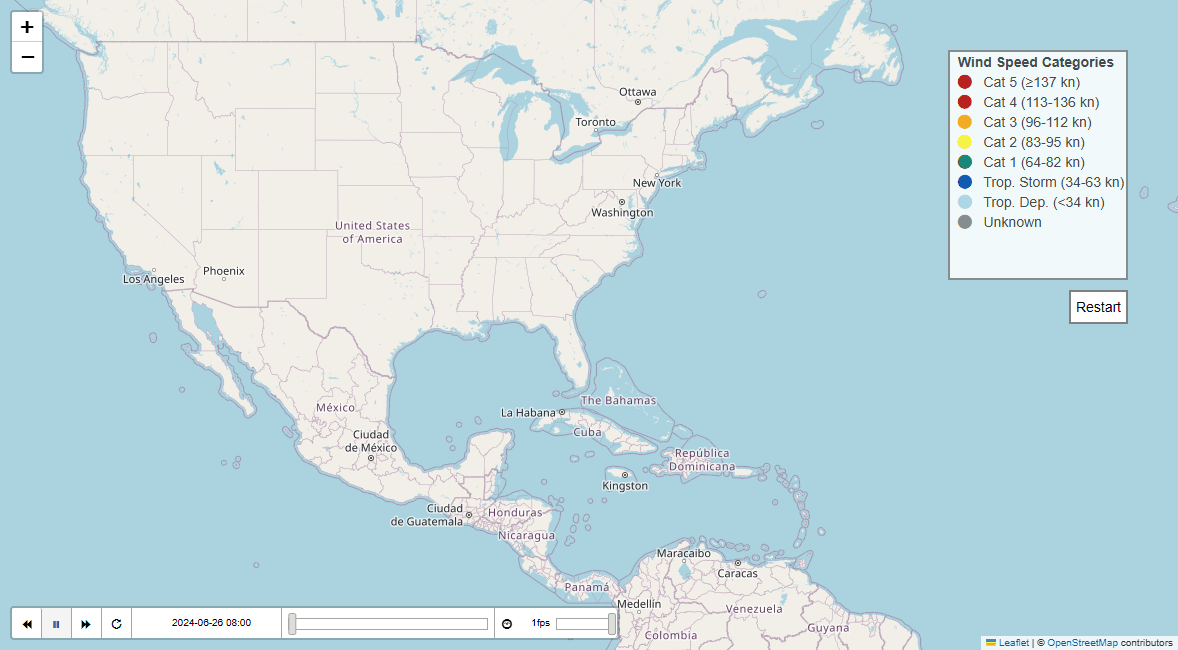

In [42]:
# Create the animated map
print("Generating Interactive Map Animation...")
animated_map = create_cyclone_folium_animation(cyclone_item, hazard_items)

if animated_map:
    display(animated_map)
    
    # Now capture this Folium animation as a GIF
    print("\n" + "="*60)
    print("Capturing Folium Animation as GIF...")
    print("="*60)
    gif_filename = "beryl_cyclone_folium.gif"
    saved_gif = create_cyclone_gif_from_folium(animated_map, filename=gif_filename, duration=15, fps=2)
    
    if saved_gif:
        print(f"\n✓ GIF saved: {saved_gif}")
        print(f"You can download it from the file explorer!")
        # Display the GIF in the notebook
        display(Image(filename=saved_gif))
    else:
        print("\n✗ Could not create GIF. Make sure Selenium and ChromeDriver are installed.")
else:
    print("Could not generate animated map.")